In [14]:
import random
import equadratures as eq
import numpy as np
import matplotlib.pyplot as plt

from ModelTree import ModelTree
from linear_regr import linear_regr

from sklearn.metrics import mean_squared_error
import scipy.stats as st

In [15]:
def sample(N, f, sample_from):
    X, y = [], []
    for i in range(N):
        x = sample_from[0] + random.random() * (sample_from[1] - sample_from[0])
        X.append(np.array(x))
        y.append(np.array(f(x, True)))
    return np.array(X), np.array(y)

In [16]:
def evaluate(model, f, sample_from):
    X, y = sample(30, f, sample_from)
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))

    return mean_squared_error(y, model.predict(X))

In [65]:
def plot(models, f, X_train, y_train):
    
    x_test = np.reshape(np.linspace(-.5, 1.5, 100), (100, 1))
    X_train = np.reshape(X_train, (X_train.shape[0], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))

    fig = plt.figure(figsize=(16, 9), dpi= 50)
    ax = fig.add_subplot(1,1,1)
    
    
    
    plt.scatter(X_train[:,0], y_train[:,0], marker='o', s=80, color='blue', label='Training data')
    
    plt.plot(x_test, [f(x, False) for x in x_test], 'k-', label='True function', color = 'black')

    colours = ['green', 'red', 'purple']
    i = 0
    
    for model in models:
        model.fit(X_train,y_train)
        
        if model.__class__.__name__ == 'ModelTree':
            print(f"Function: {f.__name__}, Model: {model.model.__class__.__name__}, Error (MSE) in [-0.5,1.5]: {evaluate(model,f,[-0.5,1.5])}")
            plt.plot(x_test, model.predict(x_test), 'k-', label=str(model.model.__class__.__name__), color = colours[i])
        
        else:
            print(f"Function: {f.__name__}, Model: {model.__class__.__name__}, Error (MSE) in [-0.5,1.5]: {evaluate(model,f,[-0.5,1.5])}")
            plt.plot(x_test, model.predict(x_test), 'k-', label=str(model.__class__.__name__), color = colours[i])
        
        
        plt.xlabel('$X$', fontsize=13)
        plt.ylabel('$Y$', fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        i += 1
    
    ax.set_ylim([-3,4])

    plt.legend(prop={'size': 20})

In [18]:
class Poly:
    def __init__(self, order):
        self.order = order
        self.poly = False
        
    def fit(self, X, y):

        param = eq.Parameter(distribution='Uniform', lower=0, upper=1., order=self.order)
        myParameters = [param for i in range(1)] # one-line for loop for parameters
        
        myBasis = eq.Basis('Univariate')
        self.poly = eq.Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':X, 'sample-outputs':y} )
        self.poly.set_model()
        
    def predict(self, X):
        return self.poly.get_polyfit(np.array(X))

In [19]:
class LinTree:
    def __init__(self):
        self.poly = Poly(1)
    
    def fit(self,X,y):
        self.poly.fit(X,y)
        
    def predict(self, X):
        return self.poly.predict(X)
    
    def loss(self, X, y, y_pred):
        return mean_squared_error(y, y_pred)
    

In [20]:
class PolyTree:
    def __init__(self):
        self.poly = Poly(3)
    
    def fit(self,X,y):
        self.poly.fit(X,y)
        
    def predict(self, X):
        return self.poly.predict(X)
    
    def loss(self, X, y, y_pred):
        return mean_squared_error(y, y_pred)
    

In [21]:
def f_orig(x, noise):
    
    if noise:
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0

    if x < 0.5:
        return 20*x**3 + x + 0.5 + noise
    elif x > 0.5:
        return -x**2 + x + noise

In [22]:
def f_osc(x, noise):
    
    if noise:
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return 25*(x-0.25)**2 - 1.0625 + noise
    elif x > 0.5:
        return 25*(x-0.75)**2 - 1.0625 + noise

In [23]:
def f_change(x, noise):
    if noise: 
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return 0.5 + noise
    else:
        return 25*(x-0.75)**2 - 1.0625 + noise

In [24]:
def f_anomaly(x, noise):
    if noise: 
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0
    return 10*(x-0.5)**3 + noise

Below we train the models with $x \in [0,1]$ and evaluate the MSE of the model where $x \in [-0.5,1.5]$

Function: f_orig, Model: Poly, Error (MSE) in [-0.5,1.5]: 21.229144568761583
Function: f_orig, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 1.6551461694165814
Function: f_anomaly, Model: Poly, Error (MSE) in [-0.5,1.5]: 0.09692983836542737
Function: f_anomaly, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 0.08933550810796737
Function: f_anomaly, Model: Poly, Error (MSE) in [-0.5,1.5]: 0.25400843985058824
Function: f_anomaly, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 0.35152264510085873


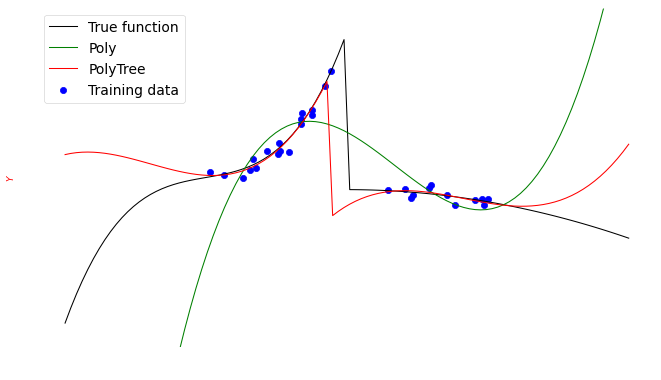

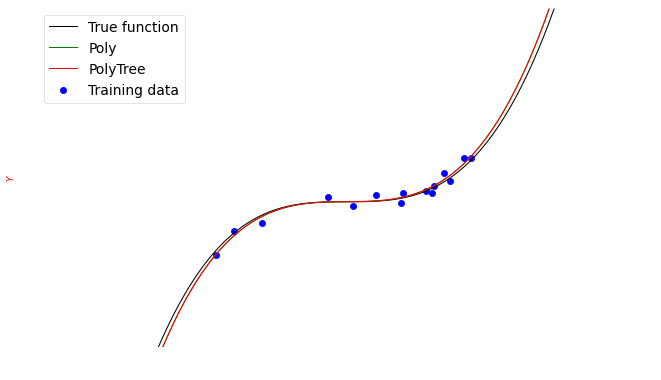

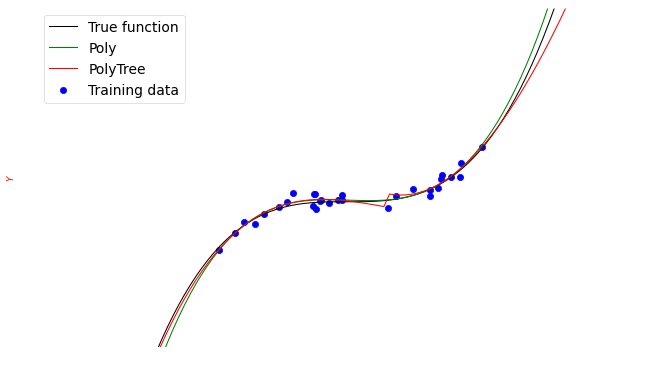

In [64]:
i = 0
samples = [30,15,30,20,20]
for f in [f_orig, f_anomaly, f_anomaly]:
    X, y = sample(samples[i], f, [0,1])
    
    if i == 3:
        X = np.append(X,0.5)
        y = np.append(y,3)
        
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))

    poly = Poly(3)

    poly_model = PolyTree()
    poly_model_tree = ModelTree(poly_model, max_depth=3, min_samples_leaf=10,
                           search_type="greedy", n_search_grid=100)
    
    linear_model = LinTree()
    linear_regr_tree = ModelTree(linear_model, max_depth=3, min_samples_leaf=10,
                           search_type="greedy", n_search_grid=100)

    plot([poly, poly_model_tree], f, X, y)
    
    
    
    i+=1

# Regression using polynomial trees 
This blog post describes and justifies the implementation of a new regression method for Effective Quadratures (EQ). We hope to make it clear the cases in which polynomial regression trees would be well suited, as well as highlight some of the drawbacks associated with this method. 

Currently in EQ, global polynomial regresssion has been implemented. This method provides the ability to quickly generate a surrogate model that is robust to noise in the training data as demonstrated below. On the other hand it performs poorly with  functions such as:
 - Discontinuous functions
 - Polynomial functions with a order change

In order to justify these claims we use  [Anson Wong's model tree](https://github.com/ankonzoid/LearningX/tree/master/advanced_ML/model_tree) with the EQ Poly class as the model. It should be noted that for simplicity a few restrictions have been made. The main restriction made is that a fixed order of 3 is chosen for all polynomials in the following examples. Additionally all example datasets are 2 dimensional for the purpose of visualisation. 

A discontinuous function $f(x)$ with $x \in [0,1]$ is constructed from two polynomial functions with added noise. Using 30 training samples from the function we can see the PolyTree is able to identify the break between the functions, resulting in signifigantly less error when compared to the global Poly approximation

Function: f_orig, Model: Poly, Error (MSE) in [-0.5,1.5]: 17.929889403294965
Function: f_orig, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 0.4897379071744974


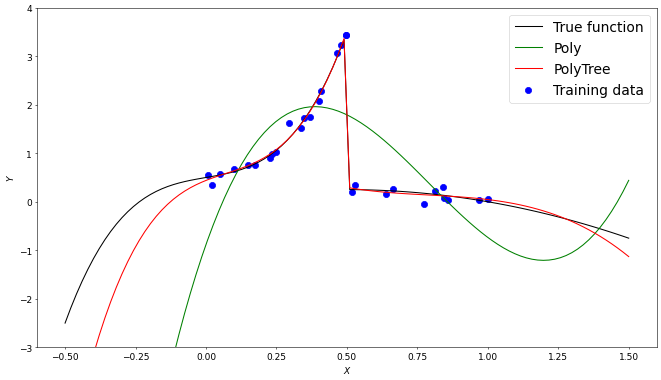

In [61]:
X, y = sample(30, f_orig, [0,1])
X = np.reshape(X, (X.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

poly = Poly(3)

poly_model = PolyTree()
poly_model_tree = ModelTree(poly_model, max_depth=3, min_samples_leaf=10,
                       search_type="greedy", n_search_grid=100)

plot([poly, poly_model_tree], f_orig, X, y)


Another function $g(x)$ with $x \in [0,1]$ is constructed from two polynomial functions with added noise. The two polynomial functions have different orders and, along with the previous example, demonstrate the ability for the tree to adapt to functions with several functional forms.

Function: f_change, Model: Poly, Error (MSE) in [-0.5,1.5]: 10.90796731063154
Function: f_change, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 4.192931102344312


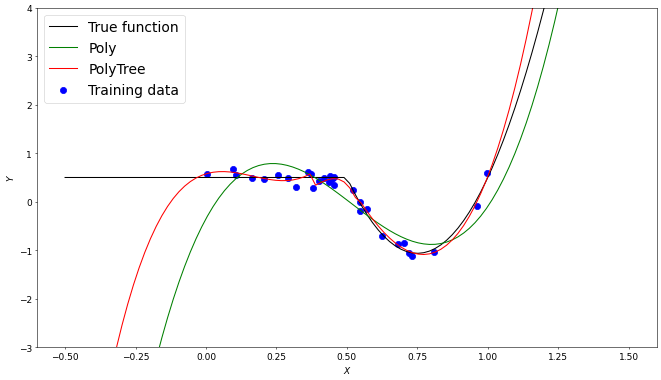

In [27]:
X, y = sample(30, f_change, [0,1])
X = np.reshape(X, (X.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

poly = Poly(3)

poly_model = PolyTree()
poly_model_tree = ModelTree(poly_model, max_depth=3, min_samples_leaf=10,
                       search_type="greedy", n_search_grid=100)

linear_model = LinTree()
linear_regr_tree = ModelTree(linear_model, max_depth=3, min_samples_leaf=10,
                           search_type="greedy", n_search_grid=100)

plot([poly, poly_model_tree], f_change, X, y)

One limitation of the polynomial tree method is that as the training data is divided, overfitting becomes more likely. A demonstration of this is seen below, where the global Poly method approximation is relatively uneffected by an anomaly at $(0,1)$ in comparison to the tree method, which is significantly skewed.

Function: f_anomaly, Model: Poly, Error (MSE) in [-0.5,1.5]: 0.036247053049143295
Function: f_anomaly, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 0.8553692131216162
Function: f_anomaly, Model: Poly, Error (MSE) in [-0.5,1.5]: 1.729428790433164
Function: f_anomaly, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 240.70857569581256


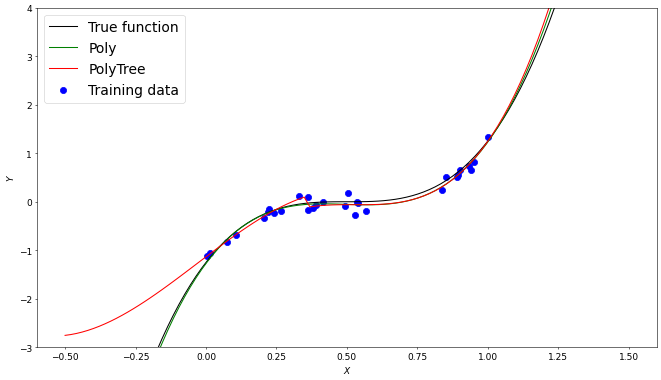

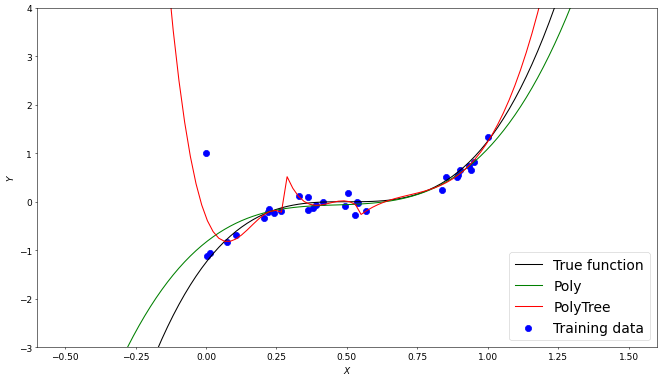

In [28]:
X, y = sample(30, f_anomaly, [0,1])

X = np.reshape(X, (X.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

poly = Poly(3)

poly_model = PolyTree()
poly_model_tree = ModelTree(poly_model, max_depth=3, min_samples_leaf=10,
                       search_type="greedy", n_search_grid=100)

plot([poly, poly_model_tree], f_anomaly, X, y)

X = np.append(X,np.array([0]))
y = np.append(y,np.array([1]))

plot([poly, poly_model_tree], f_anomaly, X, y)


Another comparison to be made is one between a linear and polynomial regression tree. The main reason we would not want to implement a linear regression tree is that the functions we want to model are very rarely linear. Due to this linear model trees will require a greater depth and as mentioned in the previous example, a greater depth will generally result in more overfitting. In the following example we adjust the hyperparameters of the linear tree so that its model has roughly the same error as the polynomial model. This results in 7 separate linear models compared to the 2 polynomial models used. 

Function: f_osc, Model: Poly, Error (MSE) in [-0.5,1.5]: 34.877052477329485
Function: f_osc, Model: PolyTree, Error (MSE) in [-0.5,1.5]: 5.374336056465038
Function: f_osc, Model: LinTree, Error (MSE) in [-0.5,1.5]: 6.72082472644513


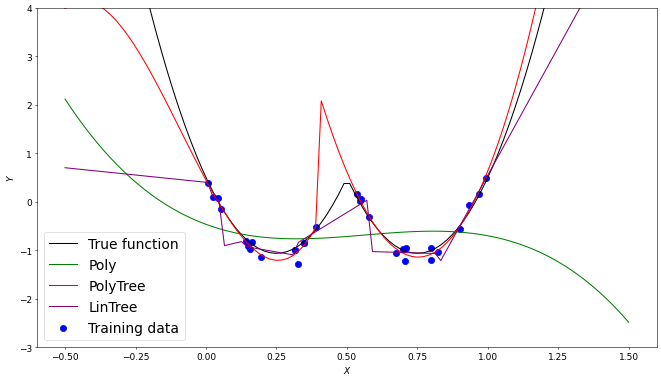

In [58]:
X, y = sample(30, f_osc, [0,1])

X = np.reshape(X, (X.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

poly = Poly(3)

poly_model = PolyTree()
poly_model_tree = ModelTree(poly_model, max_depth=3, min_samples_leaf=10,
                       search_type="greedy", n_search_grid=100)

linear_model = LinTree()
linear_regr_tree = ModelTree(linear_model, max_depth=3, min_samples_leaf=1,
                       search_type="greedy", n_search_grid=100)

plot([poly, poly_model_tree, linear_regr_tree], f_osc, X, y)

# Conclusion and future plans
In this blog we have demonstrated the benefits of implementing an orthogonal polynomial regression tree class in EQ, as well as highlighted examples in which it would not be a suitable model to use. Over the coming weeks we will compare various approaches for deciding where to "split" the tree.